# Preliminaries
## Overview of model
NOAA Global Systems Laboratory: https://gsl.noaa.gov/focus-areas/regional-models and information on their smoke model:
>GSL's experimental Rapid Refresh - Smoke (RAP-Smoke) and High-Resolution Rapid Refresh-Smoke (HRRR-Smoke) models simulate the emissions and transport of smoke from wildfires and the impact of smoke on the weather. RAP-Smoke and HRRR-Smoke predict the 3D movement of fire-emitted fine particulate matter (PM 2.5 or fire smoke).

Information on the model and its usage:
- Quick guide to the smoke model: https://rapidrefresh.noaa.gov/hrrr/HRRRsmoke/HRRR_Smoke_IMET_Fire_QuickGuide_Aug14.pdf
- Less quick guide: https://rapidrefresh.noaa.gov/hrrr/HRRRsmoke/HRRR-Smoke_VIIRS_Activefire_user_guide.pdf
- Slides on the model: https://csl.noaa.gov/projects/firex-aq/resources/education/HRRR-Smoke2019.pdf
## Model specifications
**Temporal resolution:**
- Fresh data given hourly
- Every 6 hours (00, 06, 12, 18), model is initialized giving long-range forecasts 48 hours out.
- On every hour outside the given four, the model gives forecasts 18 hours out.

**Spatial resolution:**
- 3km horizontal grid
- 50 vertical levels

**Data used:**
- Meteorological observations
    - Radar, 3d aircraft
    - Assimilated every hour
- Boundary conditions
    - Meteorological, smoke from RAP-Smoke model
- Polar-orbiting fire radiative power (FRP) data
    - VIIRS, MODIS
## Web visualization from archived data
NOAA has a web application for visualizations. For example, here's Jan 10 smoke forecast (Eaton and Palisades), 48 hour forecast: 
- https://rapidrefresh.noaa.gov/hrrr/HRRRsmoke/jsloopUpdated.cgi?dsKeys=hrrr_ncep_smoke_jet:&runTime=2025011000&plotName=trc1_SouthCA_sfc&fcstInc=60&numFcsts=49&model=hrrr&ptitle=HRRR-Smoke%20Graphics&maxFcstLen=48&fcstStrLen=-1&domain=SouthCA&adtfn=1&resizePlot=1

They also have current forecasts on an interactive map:
- https://apps.gsl.noaa.gov/smoke/#

Here's a tutorial using the HRRR Smoke model on the web: 
 - https://www.weather.gov/mfr/HRRR_smoke_tutorial
## Getting the data
### Parameters: `MASSDEN` and `COLMD`
On the web application it's labeled near-surface smoke, but you can't tell using the NCEP Inventory because it's named something annoying called "Mass Density", or `MASSDEN` and Total Column-Integrated Mass Density, or `COLMD` (https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html)
>The smoke variables often have misleading official names. The notes section of the table explains what they actually are. Additionally, the near-surface smoke parameter (MASSDEN 8m_above_ground) was reported with units of μg/m3 until 21 December 2021, when it was then corrected to kg/m3
- MASSDEN: Fire emitted fine particulate matter (PM2.5, or fire smoke) concentrations at ~8 meters above the ground.
- COLMD: Simulated total PM2.5 mass within vertical columns over each model grid cell. Columns are ~25 kilometers above the ground. Product displays the effect of fire smoke load that includes smoke in the boundary layer as well as aloft, illustrating the integral effect of fire smoke throughout the atmosphere.
### Location of data
Data is provided by the NOAA Open Data Dissemination Program
- See: https://www.noaa.gov/nodd/about.

Herbie is able to pull data from these sources.
- See: https://herbie.readthedocs.io/en/stable/user_guide/background/data_sources.html

#### Archived
NOAA stored archived data in many places; Azure, AWS, GCP. There is a tool called `herbie` (https://github.com/blaylockbk/Herbie?tab=readme-ov-file) in python that is quite powerful, that allows you to:
- Get archived data
- Read GRIB data
- Visualize

This is one of the places where they get the data from. It is managed by NOAA:
- https://hrrrzarr.s3.amazonaws.com/index.html

Understanding the archive data:
- https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/python_data_loading.html
#### Current
NOMADS is where you pull current data:
- https://nomads.ncep.noaa.gov/gribfilter.php?ds=hrrr_2d

You can use `herbie` to pull from NOMADS.

Note: The temptation is to always use NOMADS since it is the most updated; however, there are download limits. The AWS repository has a slightly higher latency, but counts as archive data with, to my knowledge, no download limits.

# Acquiring the data

## Using Herbie to pull data

In [1]:
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

The `Herbie` class can specify details about the model you want to pull:
- Model initialization time (Hourly)
- Model name (HRRR in this case)
- Forecast step (https://herbie.readthedocs.io/en/stable/user_guide/background/model-info/hrrr.html#forecast-hour)
- Model product (https://herbie.readthedocs.io/en/stable/user_guide/background/model-info/hrrr.html#products)

Read more about the `Herbie` class usage: https://herbie.readthedocs.io/en/latest/api_reference/_autosummary/herbie.core.Herbie.html

In [2]:
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


This gives us:
- HRRR model
- Surface fields product
- 1-10-25 @ 5pm PST
- GRIB2 files, from the archives @ AWS

## Examine data to pull

In [3]:
# shows other available products
H.PRODUCTS

{'sfc': '2D surface level fields; 3-km resolution',
 'prs': '3D pressure level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [4]:
# or a neat function that prints all the attributes of the object
H.tell_me_everything()

self.DESCRIPTION=High-Resolution Rapid Refresh - CONUS
self.DETAILS={'NOMADS product description': 'https://www.nco.ncep.noaa.gov/pmb/products/hrrr/', 'University of Utah HRRR archive': 'http://hrrr.chpc.utah.edu/'}
self.EXPECT_IDX_FILE=remote
self.IDX_STYLE=wgrib2
self.LOCALFILE=hrrr.t00z.wrfsfcf00.grib2
self.PRODUCTS={'sfc': '2D surface level fields; 3-km resolution', 'prs': '3D pressure level fields; 3-km resolution', 'nat': 'Native level fields; 3-km resolution', 'subh': 'Subhourly grids; 3-km resolution'}
self.SOURCES={'aws': 'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20250110/conus/hrrr.t00z.wrfsfcf00.grib2', 'nomads': 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/hrrr/prod/hrrr.20250110/conus/hrrr.t00z.wrfsfcf00.grib2', 'google': 'https://storage.googleapis.com/high-resolution-rapid-refresh/hrrr.20250110/conus/hrrr.t00z.wrfsfcf00.grib2', 'azure': 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20250110/conus/hrrr.t00z.wrfsfcf00.grib2', 'pando': 'https://pando-rgw01.chp

Using this inventory file (https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html), I got the parameter for near-surface smoke, `MASSDEN`.

## Downloading a subset of the data

In [5]:
ds = H.xarray("MASSDEN")
ds

/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-01-10
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

# Visualization (One still image)

https://herbie.readthedocs.io/en/latest/user_guide/tutorial/EasyMap.html

## $\frac{kg}{m^3}$ to $\frac{\mu g}{m^3}$ conversion to visualize PM2.5
The units for smoke density were change from micrograms per cubic meter to kilograms per cubic meter (https://www.weather.gov/media/notification/pdf2/scn21-86rap_and_hrr_smoke_units_change_aab.pdf). We change them back to micrograms to leverage AQI's colors, which measures PM2.5 with micrograms per cubic meter.

I arbitrarily chose a PM2.5 density of 2.1 as the baseline. If you allow a 0 baseline, the entire map is just covered in green.

In [6]:
micro_per_k = 1000000000 
moderate_quality = 12.1
ds["mdens"] = ds.mdens.where(ds.mdens * micro_per_k > moderate_quality - 10)
display(ds.mdens)

<xarray.DataArray 'mdens' (y: 1059, x: 1799)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(1059, 1799), dtype=float32)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-01-10
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Attributes: (12/39)
    GRIB_paramId:                             400000
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_stepRange:                           0
    GRIB_units:                               kg m**-3
    long_name:                                Mass density
    units:                                    kg m**-3
    standard_name:                            unknown
    grid_mapping:                             gribfile_projection

## Define the plot function

In [7]:
import numpy as np
def plot(ds, coords=None, save=False):
    plt.figure()
    ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 8]).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_k,
        transform=pc,
        #transform=ccrs.PlateCarree(),
        **paint.AQIPm25.kwargs2,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **paint.AQIPm25.kwargs2,
    )
    
    ax.set_title(
        f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()

## Visualizing CONUS, LA, and SoCal

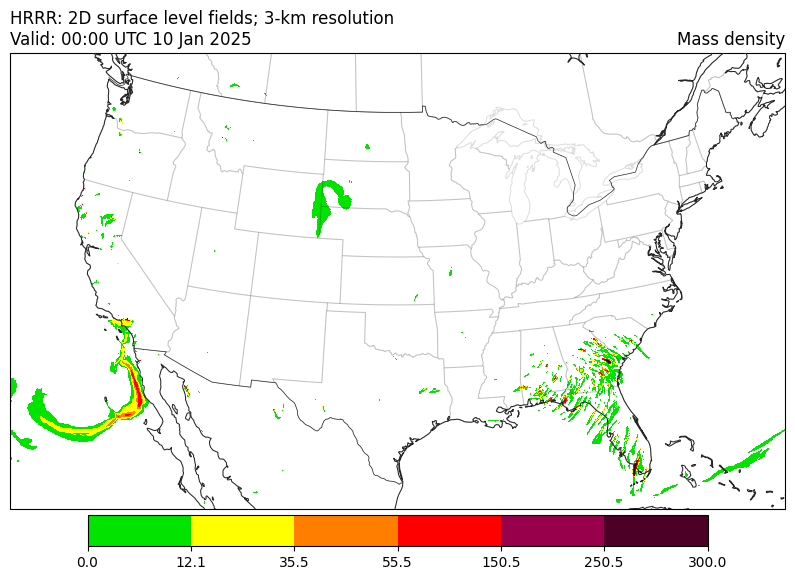

<Figure size 640x480 with 0 Axes>

In [8]:
# lat min, lat_max; long min, long max
coords = {
    "LA" : [-119.1, -117.3, 33.28, 34.86],
    "SOCAL": [-121.34, -114.13, 32.53, 35.79],
}
plot(ds, save=True)

The image we're comparing to:

![](https://rapidrefresh.noaa.gov/hrrr/HRRRsmoke/displayMapUpdated.cgi?keys=hrrr_ncep_smoke_jet:&runtime=2025011000&plot_type=trc1_full_sfc&fcst=000&time_inc=60&num_times=49&model=hrrr&ptitle=HRRR-Smoke%20Graphics&maxFcstLen=48&fcstStrLen=-1&domain=full&adtfn=1)

https://rapidrefresh.noaa.gov/hrrr/HRRRsmoke/displayMapUpdated.cgi?keys=hrrr_ncep_smoke_jet:&runtime=2025011000&plot_type=trc1_full_sfc&fcst=000&time_inc=60&num_times=49&model=hrrr&ptitle=HRRR-Smoke%20Graphics&maxFcstLen=48&fcstStrLen=-1&domain=full&adtfn=1

It looks like they used a colorbar with different ticks, but its fundamentally the same.

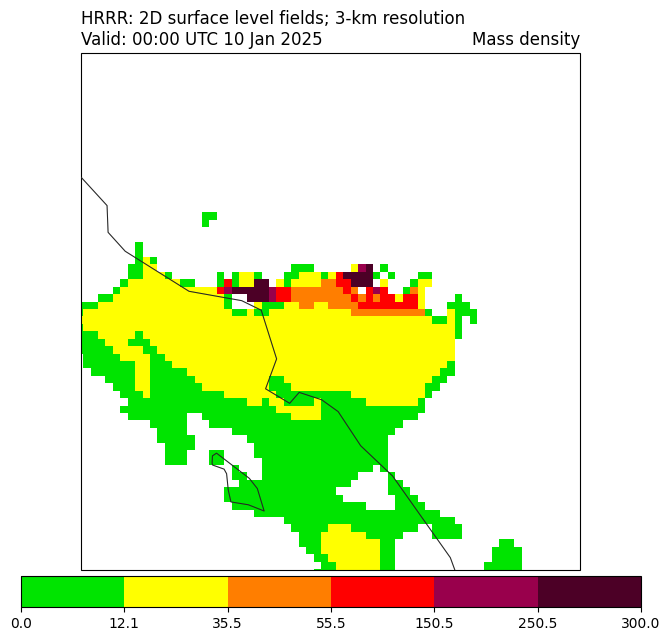

<Figure size 640x480 with 0 Axes>

In [9]:
plot(ds, coords["LA"])

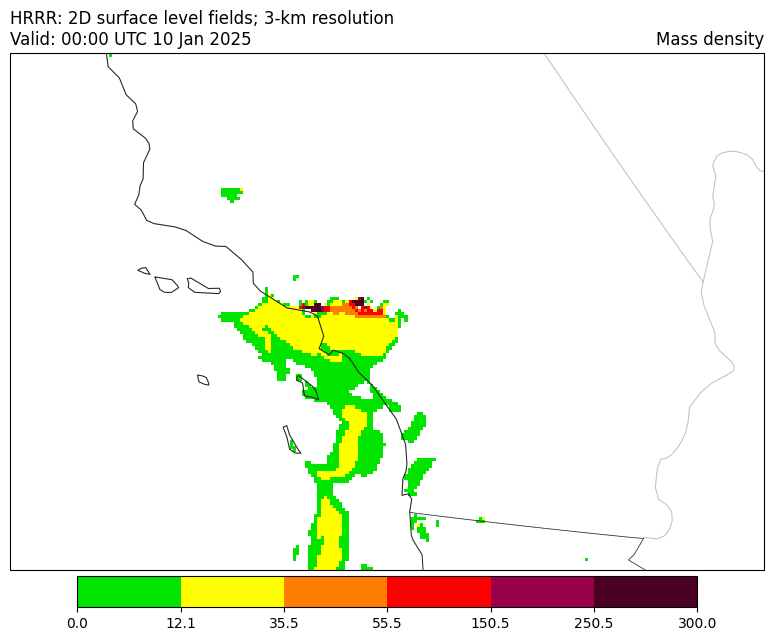

<Figure size 640x480 with 0 Axes>

In [10]:
plot(ds, coords["SOCAL"])

# Visualization (GIF of the entire 48 hour forecast)

## Pull data from all 12 hours of the forecast

In [11]:
# get 1/10/25 forecast at 00:00 UTC for the next 12 hours
forecasts = []
for i in range(1, 13):
    forecasts.append(
        Herbie(
            "2025-01-10-00",
            model="hrrr",
            product="sfc",
            fxx=i
        )
    )

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F07 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F10 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F11 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

In [12]:
# get the mass density data for each of the forecast time steps
# then convert massden data to mcg/m^3, with PM2.5=2.1 cutoff
ds_list = []
for i, model in enumerate(forecasts):
    ds_list.append(model.xarray("MASSDEN"))
    ds = ds_list[-1]
    ds["mdens"] = ds.mdens.where(ds.mdens * micro_per_k > moderate_quality - 10)
    print(f"Forecast at hour {i+1} downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.")


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 1 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 2 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 3 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 4 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 5 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 6 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 7 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 8 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 9 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 10 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Forecast at hour 11 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.
Forecast at hour 12 downloaded, with MASSDEN converted to mcg/m^3 with PM2.5 of 2.1 cutoff.


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


## Plot and save images, then create the gif

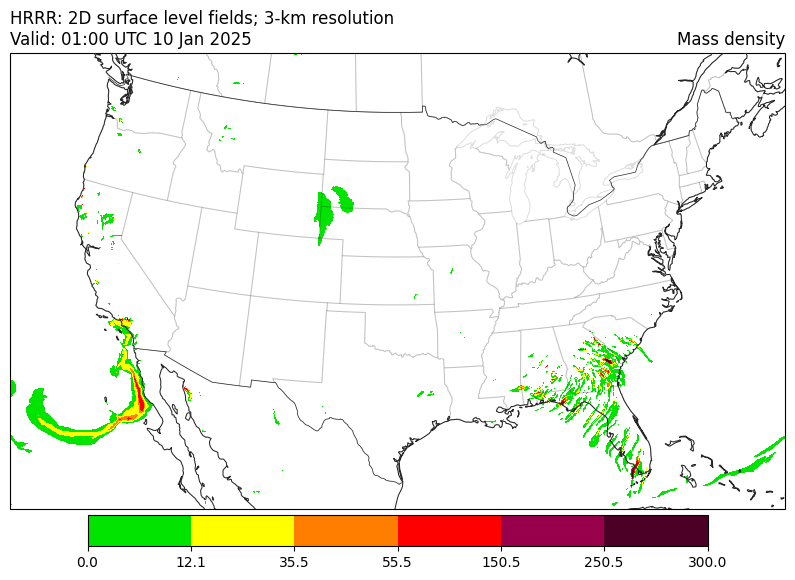

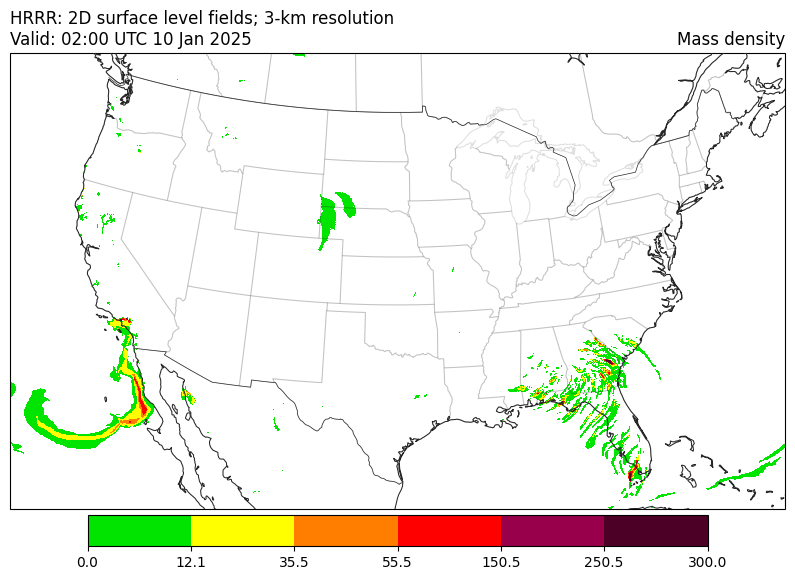

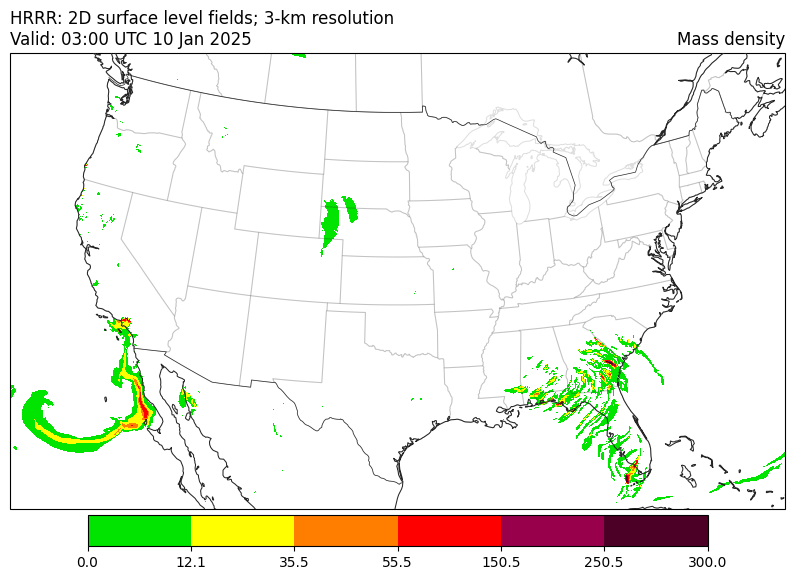

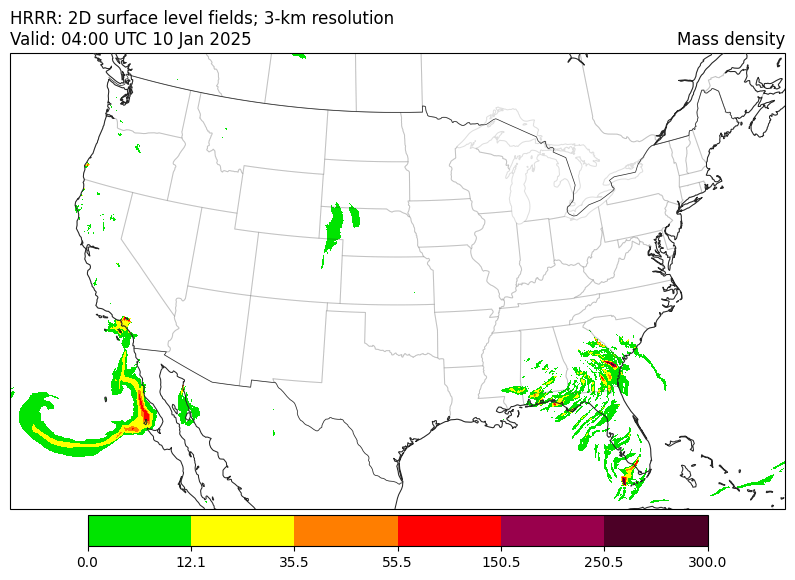

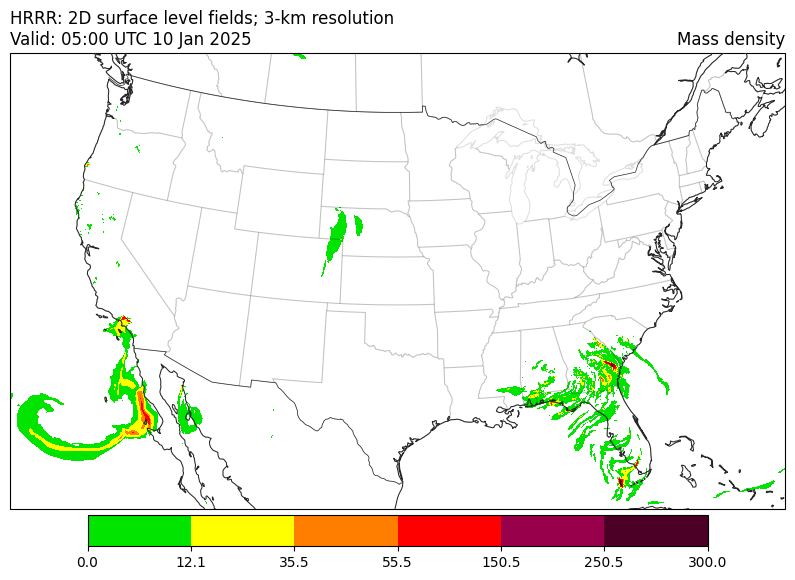

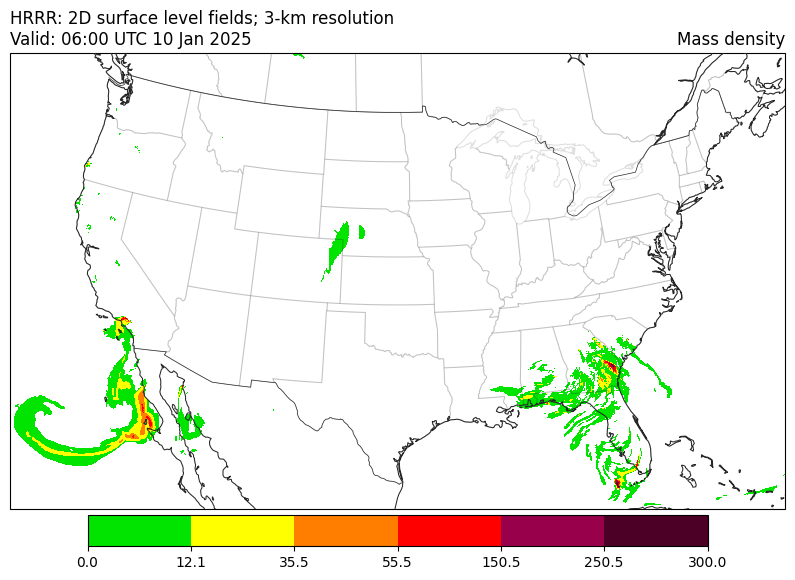

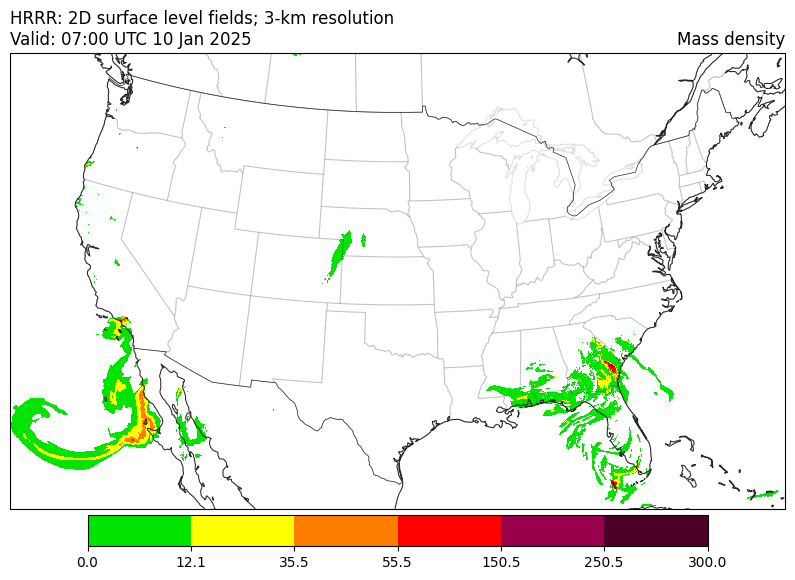

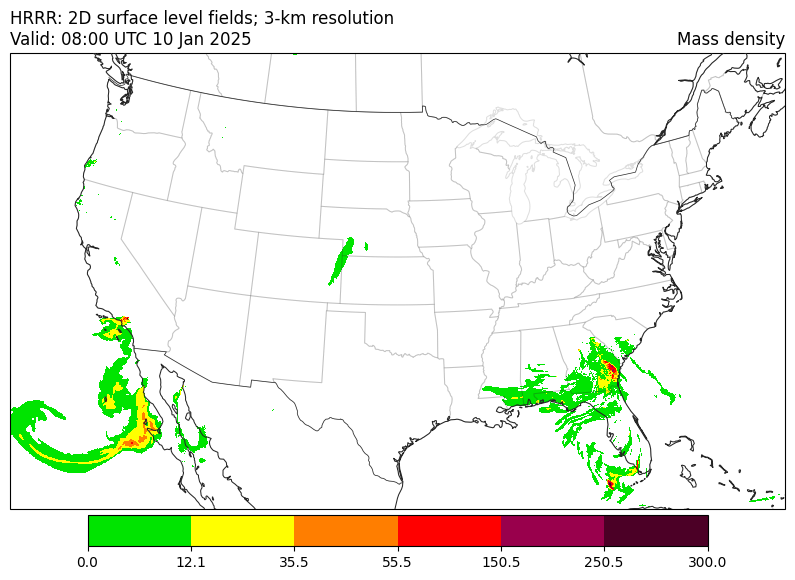

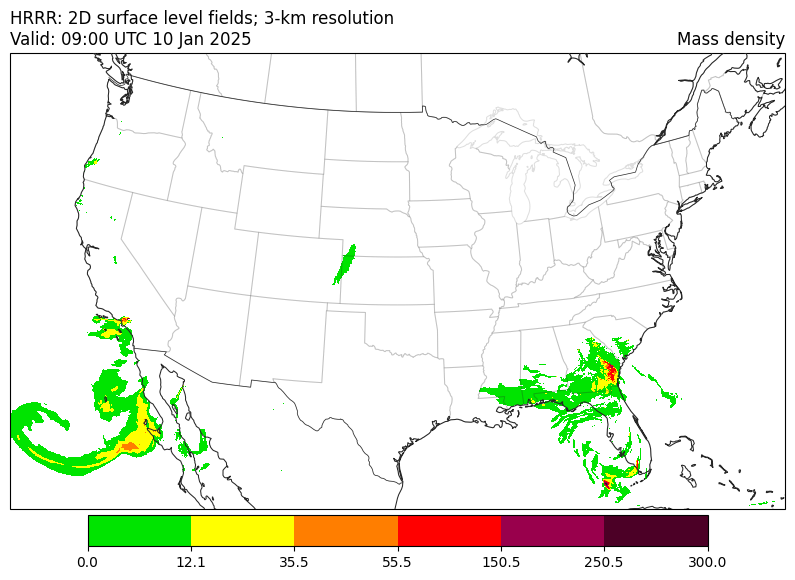

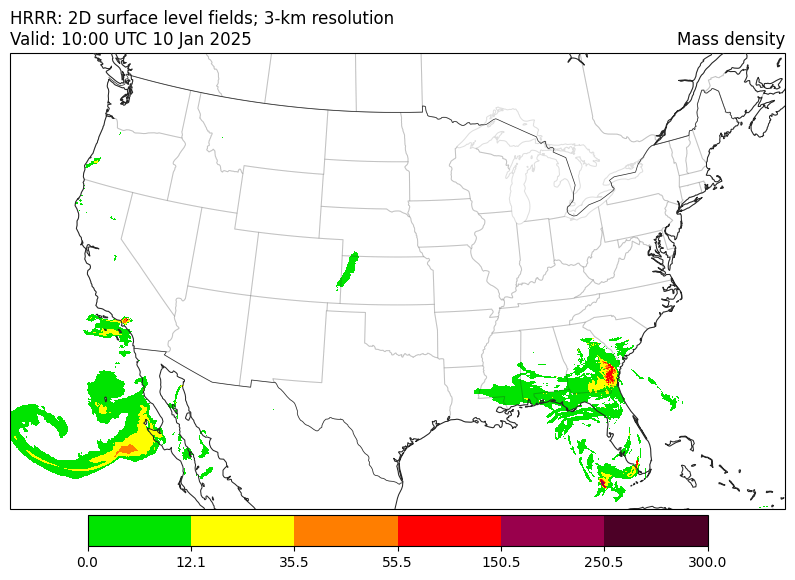

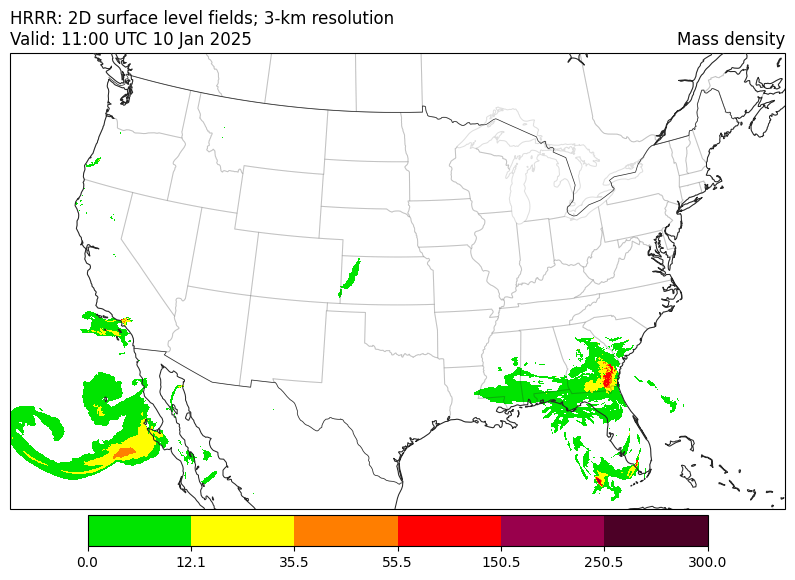

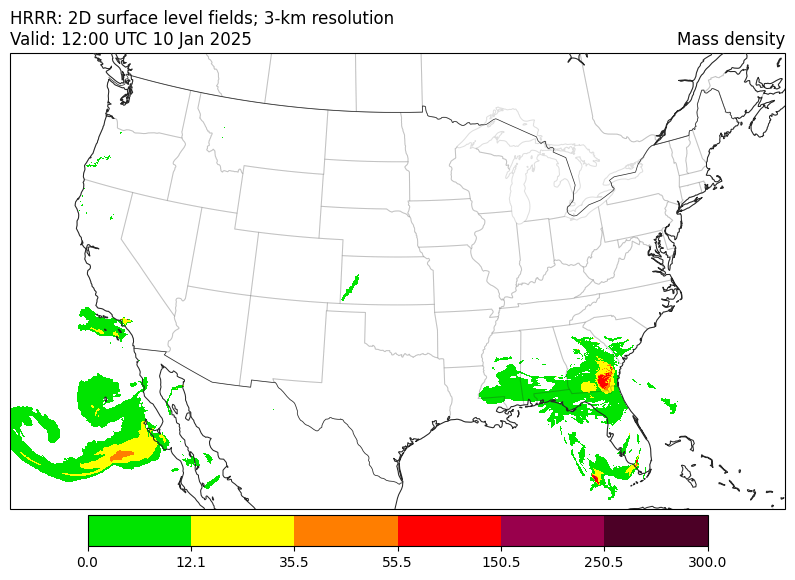

Images received: (13, 800, 1000, 4)


<Figure size 640x480 with 0 Axes>

In [13]:
import glob
from PIL import Image

# plot results, save images
for result in ds_list:
    plot(result, coords=None, save=True)

# read images
image_path = sorted(glob.glob(r"images/*.png"))
forecast_images = []
for file in image_path:
    image = Image.open(file)
    forecast_images.append(image)
print('Images received:', np.array(forecast_images).shape)

In [14]:
# Stitch the images together to create a gif
forecast_images[0].save(
    "images/full_forecast.gif", 
    save_all=True, 
    append_images=forecast_images[1:], 
    duration=500, 
    loop=0
)

![](images/full_forecast.gif)